## Neural Style Transfer 
## DD2424 Project based on : 'A Neural Algorithm of Artistic Style' Leon A. Gatys,Alexander S. Ecker,Matthias Bethge


### Import packages and libraries

In [56]:
import os 
import tensorflow as tf
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model


import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

## Functions

In [57]:
def loadImg(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  img = tf.image.resize(img, (224, 224))
  return img

def imShow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  plt.imshow(image)
  
  if title:
    plt.title(title)

def vgg_model(layers): 
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layers]
    model = tf.keras.Model([vgg.input], outputs)
    return model

def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)


## Prepare the model VGG19 (correct)

In [58]:
#Following the method of the paper : we first import the VGG19-Network. The
#feature space provided by the 16 convolutional and 5 pooling layers of the 19 #layer VGGNetwork

VGG19 = tf.keras.applications.VGG19(include_top=False)

content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1','block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Extract features from content and style image (correct)

Content features Size : 
(1, 14, 14, 512)
Style features Size : 
(1, 224, 224, 64)
(1, 112, 112, 128)
(1, 56, 56, 256)
(1, 28, 28, 512)
(1, 14, 14, 512)


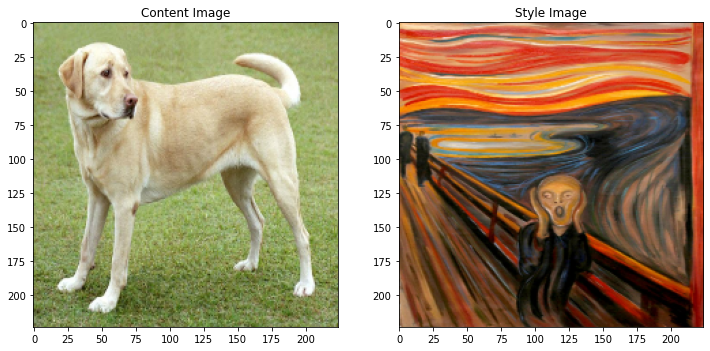

In [59]:
#Get the path of the pictures we want

#content_path = tf.keras.utils.get_file('jul.jpg', 'https://img.lemde.fr/2020/11/18/494/0/8688/4340/1440/720/60/0/7d2c869_856070765-jul-fifou-0888.jpg')
#style_path = tf.keras.utils.get_file('titiandgros.jpg', 'https://i.pinimg.com/564x/99/d3/21/99d321028e0803f9c928aadc78f934f8.jpg')

content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
#style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
#Load them
style_path = tf.keras.utils.get_file('munch.jpg','https://images.saatchiart.com/saatchi/514895/art/1854771/992742-JVTLBTPM-7.jpg')
content_img = loadImg(content_path)
style_img = loadImg(style_path)

tf_noise_image = tf.Variable(content_img)

plt.subplot(1,2,1)
imShow(content_img, 'Content Image')
plt.subplot(1,2,2)
imShow(style_img, 'Style Image')

content_img = preprocess_input(content_img*255)
style_img = preprocess_input(style_img*255)

#Extract the intermediate layers of the net and create the model
content_model = vgg_model(content_layers)
style_model = vgg_model(style_layers) #style_extractor ---->


content_model.trainable = False
style_model.trainable = False

#Create the features map of both images
content_features = content_model(content_img)
style_features = style_model(style_img) # style output ----->


#Print shapes to debug
print ("Content features Size : ")
print(content_features.shape)
print('Style features Size : ')
for i in range(len(style_features)):
    print(style_features[i].shape)

## Extract Style and Content

In [60]:
vgg = vgg_model(style_layers + content_layers)
#Build the model
vgg.trainable = False

def extract_style_content(image):
    # image btw. [0, 1]
    #image = image*255
    processed_image = preprocess_input(image)
    features = vgg(processed_image)

    #Extract style feature and gram matrix
    style_features = features[:len(style_layers)]
    style_features = [gram_matrix(feature) for feature in style_features]


    #Extract content feature
    content_features = features[len(style_layers):]

    return [style_features, content_features]


In [61]:
features = extract_style_content(style_img)
#print(features[0])

## Gradient descent

In [62]:
#extract the target we want
style_target = extract_style_content(style_img)[0]
content_target = extract_style_content(content_img)[1]

targets = [style_target, content_target]

In [63]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1 = 0.99, epsilon = 1e-1)

def style_content_loss(features):
    beta=1e-2
    alpha=1e4

    #style_features = features[0]
    #content_features = features[1]

    #targets = [style_target, content_target]

    style_tensor_list = []
    for layer in range(len(style_layers)):
        style_tensor_list.append(tf.reduce_mean((features[0][layer] - 
            targets[0][layer])**2))
    style_loss = tf.add_n(style_tensor_list)

    style_loss *= beta / len(style_layers)

    content_tensor_list = []
    for i in range(len(content_layers)):
        a = tf.reduce_mean((features[1][i]-targets[1][i])**2) 
        content_tensor_list.append(a)

    content_loss = tf.add_n(content_tensor_list)
    content_loss *= alpha / len(content_layers)
    loss = style_loss + content_loss
    return loss

style_content_loss(features)

<tf.Tensor: shape=(), dtype=float32, numpy=154863650.0>

In [64]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    features = extract_style_content(image)
    loss = style_content_loss(features)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  #print(image.numpy())
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))


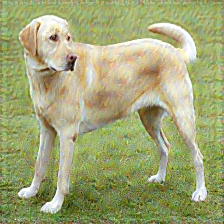

In [65]:
def tensor_to_image(tensor):
  tensor= tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

train_step(tf_noise_image)
train_step(tf_noise_image)
train_step(tf_noise_image)
tensor_to_image(tf_noise_image)